# Setup

In [1]:
import cupy as cp
import numpy as np

if cp.cuda.is_available():
	print("GPU is available")
	print("GPU: ", cp.cuda.runtime.getDeviceProperties(0)['name'])
import os
import tempfile
from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

MAKE_ANIMATIONS = True


tempdir = tempfile.TemporaryDirectory()

def make_video_from_solution(
	solution,
	quantities=("order_parameter", "phase"),
	fps=30,
	figsize=(5, 4),
	cmap=None,
	vmin_a=None,
	vmax_a=None,
	cmap_b=None,
	):
	"""Generates an HTML5 video from a tdgl.Solution."""
	with tdgl.non_gui_backend():
		with h5py.File(solution.path, "r") as h5file:
			print(cmap_b)
			anim = create_animation(
				h5file,
				quantities=quantities,
				fps=fps,
				figure_kwargs=dict(figsize=figsize, dpi=100),
				vmin=vmin_a,
				vmax=vmax_a,
				cmap=cmap_b,
			)
			video = anim.to_html5_video()
		return HTML(video)
	

	

GPU is available
GPU:  b'NVIDIA GeForce RTX 4070 SUPER'


C:\Users\cordo\AppData\Roaming\Python\Python310\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Physical properties

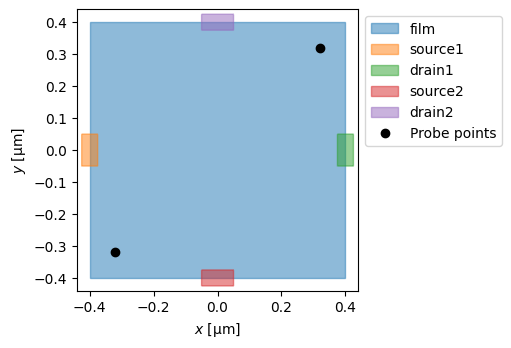

In [13]:
length_units = "um"
# Material parameters
xi = 0.1
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

width = 0.8
height = 0.8

film = tdgl.Polygon('film', points=box(width, height)).resample(401).buffer(0)


source1 = tdgl.Polygon('source1', points=box(0.05,0.1)).translate(-width/2, 0 ).buffer(0)
drain1 = tdgl.Polygon('drain1', points=box(0.05,0.1)).translate(width/2, 0 ).buffer(0)
source2 = tdgl.Polygon('source2', points=box(0.1,0.05)).translate(0,-height/2 ).buffer(0)
drain2 = tdgl.Polygon('drain2', points=box(0.1,0.05)).translate(0,height/2).buffer(0)


device=tdgl.Device("2currents",
				   layer=layer 
				   ,film=film
				   ,terminals= [source1,drain1,source2,drain2]
				   ,length_units=length_units
				   ,probe_points=[((-width*(0.4),-height*(0.4)),(width*(0.4),height*(0.4)))]
				   )

fig,ax=device.draw()

Constructing Voronoi polygons: 100%|██████████| 3944/3944 [00:02<00:00, 1573.62it/s]


min_edge_length: 5.031e-03
max_edge_length: 2.569e-02
mean_edge_length: 1.378e-02
min_area: 1.399e-05
max_area: 3.528e-04
mean_area: 1.623e-04
coherence_length: 1.000e-01


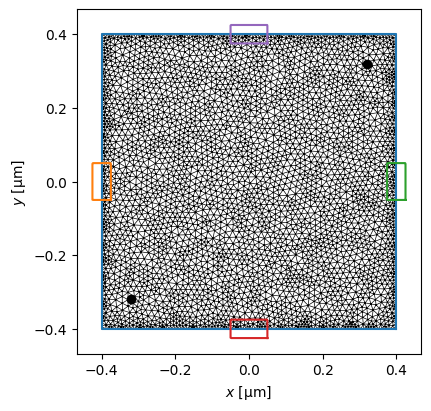

In [14]:
device.make_mesh(max_edge_length=xi / 4, smooth=100)
device.mesh_stats(print_b=True)
fig, ax = device.plot(mesh=True, legend=False)

In [ ]:


import tdgl.sources


options = tdgl.SolverOptions(
    solve_time=200,
    # output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",

)
applied_vector_potential=tdgl.sources.constant.ConstantField(30,field_units=options.field_units,length_units=device.length_units)

currents=np.linspace(0.0, 12,50 )
voltages=[]
times=[]
solutions=[]
for ii in range(currents.size):

	zero_current_solution = tdgl.solve(
		device=device,
		options=options,
		applied_vector_potential=applied_vector_potential,
		terminal_currents=dict(source1=currents[ii], drain1=-currents[ii],source2=currents[ii],drain2=-currents[ii])
	)
	# fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))
	# voltage=
	voltages.append(zero_current_solution.dynamics.voltage())
	solutions.append(zero_current_solution)
	
	times.append(zero_current_solution.dynamics.time)
	print(ii)


Simulating:   2%|▏         | 3/200 [00:04<04:20,  1.32s/tau ]


0


Simulating:  20%|█▉        | 39/200 [00:11<00:37,  4.35tau/s ]

(300,)


(0.0, 2.0)

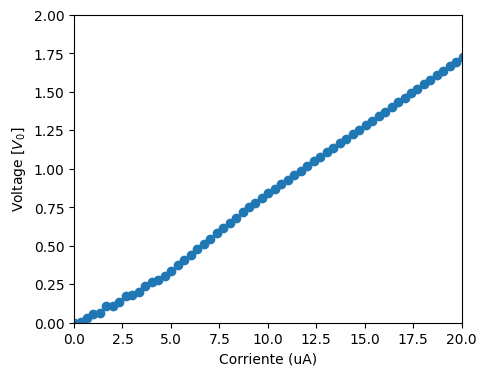

In [5]:

import csv
voltage_values=np.zeros(len(voltages))
print(voltage_values.shape)
for ii in range(len(voltages)):
	max_idx=voltages[ii].shape[0]-1
	voltage_values[ii]=np.mean(voltages[ii][max_idx])
	data_series=np.vstack((times[ii],voltages[ii]))

	np.save(f'series3/output_{ii}.npy', data_series)

plt.scatter(currents,voltage_values)
plt.xlabel("Corriente (uA)")
plt.ylabel("Voltage [$V_0$]")
# plt.plot(times[1],voltages[1])
# plt.ylim(3.66,3.673)
plt.xlim(0,20)
plt.ylim(0,2)

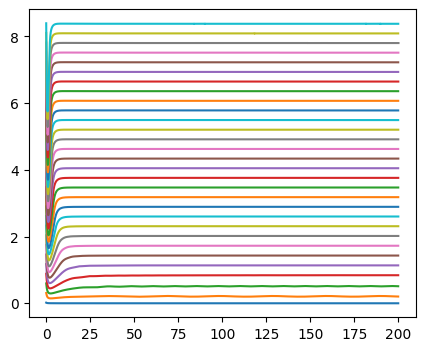

In [ ]:
for ii in range(int(len(voltages)/10)):
	plt.plot(times[ii*10],voltages[ii*10])


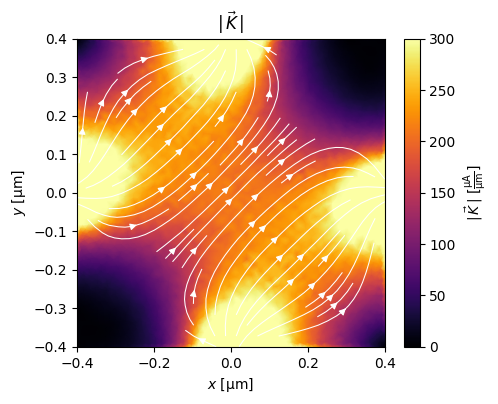

In [6]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=300)

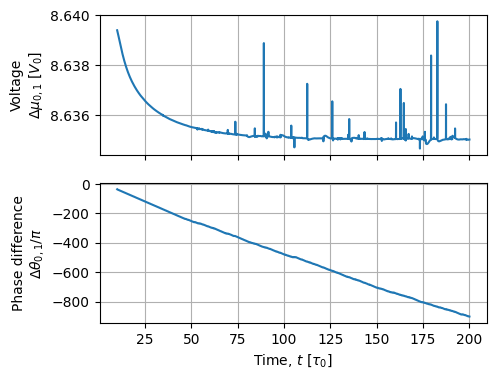

In [7]:
fig, axes = data_series.dynamics.plot(tmin=10, mean_voltage=False)

In [8]:
zero_current_solution.dynamics.mean_voltage(tmin=200)

8.635016858224057

In [9]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        solutions[1],
        quantities=["order_parameter", "phase"],
        figsize=(8, 4),
        vmax_a=[1,1],
        vmin_a=[0,-1],
        cmap_b=["gist_rainbow", "hsv"],
    )
    display(field_current_video,)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\cordo\AppData\Local\Temp\tmpefvjz5im\output.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)